In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from typing import Tuple, Union
from sklearn.utils.validation import check_is_fitted
from scipy.linalg import solve

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

import scipy

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
def plot_logit_results(df, pred_key, ax, suptitle, grid=False, error_key=None, pred_min=0, pred_max=1, error_min=0.1, error_max=0.2):
    ax.set_title(suptitle)
    #sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[pred_key], 
                bins = 100,
                #norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        if (error_key == None):
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        #hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                            palette=cmap, legend=False)
        else:
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        #hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        size=error_key, #size_norm = (0.1, 0.2), sizes=(10, 200),
                            palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

    return ax

In [4]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
patience = 30
load_values = False
save_values = False

#Data constants
shapes = [2, 6]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes


tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"
large_gridfile = f"grid_r_a1_2500_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
grid_rmax = grid_data["x1"].max()
large_grid_data = pd.read_csv(f"../data/{large_gridfile}.csv")
large_grid_rmax = large_grid_data["x1"].max()

X_test = test_data[[x1_key, x2_key]]
Y_test = test_data["class"]

X_grid = grid_data[[x1_key, x2_key]]
X_large_grid = large_grid_data[[x1_key, x2_key]]

### Uncertainties in Gaussian Processes

In [5]:
#https://stackoverflow.com/questions/67818319/how-to-output-mean-and-stdv-of-gaussian-process-classifier-in-sklearn
class LatentGPC(GaussianProcessClassifier):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def predict_a(
        self, X: np.ndarray, return_std: bool = False
    ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """
        Return estimates of the latent function for X.
        
        Notes:
        ------
        - For binary classification (n_classes = 2), the output shape is
        (n_samples,).
        - For multi-class classification, the output shape is (n_samples,
        n_classes) when multi_class="one_vs_rest", and is shaped (n_samples,
        n_classes*(n_classes - 1)/2) when multi_class="one_vs_one". In other
        terms, There are as many columns as trained Binary GPC sub-models.
        - The number of classes (n_classes) is determined by the number of
        unique target values in the training data.
        """
        check_is_fitted(self)

        if self.n_classes_ > 2:  # Multi-class case
            f_stars = []
            std_f_stars = []
            for estimator, kernel in zip(self.base_estimator_.estimators_, self.kernel_.kernels):
                result = self._binary_predict_a(estimator, kernel, X, return_std)
                if not return_std:
                    f_stars.append(result)
                else:
                    f_stars.append(result[0])
                    std_f_stars.append(result[1])

            if not return_std:
                return np.array(f_stars).T

            return np.array(f_stars).T, np.array(std_f_stars).T
        else:  # Binary case
            return self._binary_predict_a(self.base_estimator_, self.kernel_, X, return_std)

    @staticmethod
    def _binary_predict_a(estimator, kernel, X, return_std):
        """ Return mean and std of the latent function estimates for X. """
        check_is_fitted(estimator)

        # Based on Algorithm 3.2 of GPML
        K_star = kernel(estimator.X_train_, X)  # K_star = k(x_star)
        f_star = K_star.T.dot(estimator.y_train_ - estimator.pi_)  # Line 4
        if not return_std:
            return f_star

        v = solve(estimator.L_, estimator.W_sr_[:, np.newaxis] * K_star)  # Line 5
        # Line 6 (compute np.diag(v.T.dot(v)) via einsum)
        var_f_star = kernel.diag(X) - np.einsum("ij,ij->j", v, v)

        return f_star, np.sqrt(var_f_star)
    

def predictive_prob(mf, stdf):
    """Approximation to int sigma(f) N(f|mf,stdf**2) df
    where sigma is the logistic function and N is a Gaussian
    By David JC MacKay, 1992"""
    f_transform = mf/np.sqrt(1.0 + np.pi * stdf**2 / 8.0)
    
    return (1/(1+np.exp(-f_transform)))

def MC_est_mu_std(mf, stdf, N_samples:int = 1000):
    # mf and stdf are the mean and standard deviation of a normal distribution
    rng = np.random.default_rng()
    f_samples = rng.normal(mf, stdf, (N_samples, len(mf)))
    sigm_f_samples = 1/(1+np.exp(-f_samples))
    # We will use a MC estimator with f sampled from p(f) to evaluate the expectation:
    # mu = int sigmoid(f)p(f)df \approx sum sigmoid(f)
    # Var = int (sigmoid(f)-mu)p(f)df \approx sum sigmoid(f)

    return np.mean(sigm_f_samples, axis=0), np.std(sigm_f_samples, axis=0)



In [44]:


# https://www.geeksforgeeks.org/gaussian-process-classification-gpc-on-iris-dataset/
n_data = [250]#[250, 500, 1000, 2000, 3000, 5000]#, 10000]
#n_data =[70]

max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 2000:
        max_err_val[i] = 0.3
    else:
        max_err_val[i] = 0.2
        
grid_latent_dfs = [0]*(len(n_data))
large_grid_latent_dfs = [0]*(len(n_data))
test_latent_dfs = [0]*(len(n_data))
ls = 8  #Length scale
ov = 2

if load_values==False:
    for i in tqdm(range(len(n_data))):
        grid_latent_dfs[i] = pd.read_csv(f"../data/{gridfile}.csv")
        large_grid_latent_dfs[i] = pd.read_csv(f"../data/{large_gridfile}.csv")
        test_latent_dfs[i] = pd.read_csv(f"../data/{testfile}.csv")
        X_train = train_data[[x1_key, x2_key]][0:n_data[i]]
        Y_train = train_data["class"][0:n_data[i]]
        
        # Define and tune hyperparameters of GP classifier
        kernel = ov * RBF(length_scale=ls)  # RBF kernel with default parameters
        gp = LatentGPC(kernel=kernel, optimizer=None)
        print(len(X_train))
        gp.fit(X_train, Y_train)
        print(gp.kernel_)

        # Predict
        test_latent_dfs[i]["Logit_blue"], test_latent_dfs[i]["Std_logit_blue"] = gp.predict_a(X_test, return_std=True)
        test_latent_dfs[i]["Sigmoid_blue"] = 1/(1+np.exp(-test_latent_dfs[i]["Logit_blue"]))
        test_latent_dfs[i]["Prediction"] = gp.predict(X_test)

        grid_latent_dfs[i]["Logit_blue"], grid_latent_dfs[i]["Std_logit_blue"] = gp.predict_a(X_grid, return_std=True)
        grid_latent_dfs[i]["Sigmoid_blue"] = 1/(1+np.exp(-grid_latent_dfs[i]["Logit_blue"]))
        grid_latent_dfs[i]["Prediction"] = gp.predict(X_grid)

        large_grid_latent_dfs[i]["Logit_blue"], large_grid_latent_dfs[i]["Std_logit_blue"] = gp.predict_a(X_large_grid, return_std=True)
        large_grid_latent_dfs[i]["Sigmoid_blue"] = 1/(1+np.exp(-large_grid_latent_dfs[i]["Logit_blue"]))
        large_grid_latent_dfs[i]["Prediction"] = gp.predict(X_large_grid)

        test_latent_dfs[i]["Est_prob_blue"] = predictive_prob(test_latent_dfs[i]["Logit_blue"], test_latent_dfs[i]["Std_logit_blue"])
        grid_latent_dfs[i]["Est_prob_blue"] = predictive_prob(grid_latent_dfs[i]["Logit_blue"], grid_latent_dfs[i]["Std_logit_blue"])
        large_grid_latent_dfs[i]["Est_prob_blue"] = predictive_prob(large_grid_latent_dfs[i]["Logit_blue"], large_grid_latent_dfs[i]["Std_logit_blue"])

        test_latent_dfs[i]["Est_prob_blue_MC"], test_latent_dfs[i]["Std_prob_blue_MC"] = MC_est_mu_std(test_latent_dfs[i]["Logit_blue"], test_latent_dfs[i]["Std_logit_blue"], N_samples=1000)
        grid_latent_dfs[i]["Est_prob_blue_MC"], grid_latent_dfs[i]["Std_prob_blue_MC"] = MC_est_mu_std(grid_latent_dfs[i]["Logit_blue"], grid_latent_dfs[i]["Std_logit_blue"], N_samples=1000)
        large_grid_latent_dfs[i]["Est_prob_blue_MC"], large_grid_latent_dfs[i]["Std_prob_blue_MC"] = MC_est_mu_std(large_grid_latent_dfs[i]["Logit_blue"], large_grid_latent_dfs[i]["Std_logit_blue"], N_samples=1000)

        test_latent_dfs[i]["Sigmoid_std_logit_blue"] = 1/(1+np.exp(-test_latent_dfs[i]["Std_logit_blue"]))-0.5 #Scales like the mean but is only positive
        grid_latent_dfs[i]["Sigmoid_std_logit_blue"] = 1/(1+np.exp(-grid_latent_dfs[i]["Std_logit_blue"]))-0.5 #Scales like the mean but is only positive
        large_grid_latent_dfs[i]["Sigmoid_std_logit_blue"] = 1/(1+np.exp(-large_grid_latent_dfs[i]["Std_logit_blue"]))-0.5 #Scales like the mean but is only positive
        # Save prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                    os.mkdir(f"predictions/{trainfile}")
            test_latent_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
            grid_latent_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
            large_grid_latent_dfs[i].to_csv(f"predictions/{trainfile}/large_grid_{tag}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
else:
    for i in range(len(n_data)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_latent_dfs[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
        grid_latent_dfs[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
        large_grid_latent_dfs[i] = pd.read_csv(f"predictions/{trainfile}/large_grid_{tag}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")

  0%|          | 0/1 [00:00<?, ?it/s]

250
1.41**2 * RBF(length_scale=8)


100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


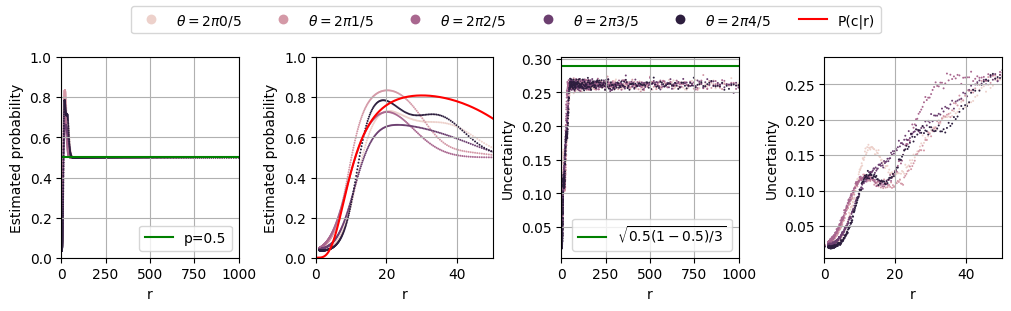

In [47]:
def plot_large_grid(df, df_truth, prob_key, err_key):

    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 3), layout="constrained")

    #Plot estimated probabilities
    sn.scatterplot(df, x="r", y=prob_key, hue="a1", ax=axs[0], s=2, linewidth=0, alpha=1, legend=False)
    #sn.lineplot(df_truth[df_truth["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[0], color="red", legend=False)
    x = [0, large_grid_rmax]
    y = [0.5, 0.5]
    axs[0].plot(x, y, c="green", label=f"p=0.5")
    axs[0].legend(loc='lower right')
    axs[0].set_ylabel("Estimated probability", size=10)
    axs[0].set_xlim(0, large_grid_rmax)
    axs[0].set_ylim(0, 1)

    sn.scatterplot(df, x="r", y=prob_key, hue="a1", ax=axs[1], s=2, alpha=1, linewidth=0, legend="full")
    sn.lineplot(df_truth[df_truth["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[1], label="P(c|r)", color="red")
    axs[1].set_ylabel("Estimated probability", size=10)
    axs[1].set_xlim(0, grid_rmax)
    axs[1].set_ylim(0, 1)

    #Plot uncertainties
    sn.scatterplot(df, x="r", y=err_key, hue="a1", ax=axs[2], s=2, linewidth=0, alpha=1, legend=False)
    x = [0, large_grid_rmax]
    #df_large_r = df.copy()[df["r"] > 700]
    #sigma = np.sqrt((df_large_r[prob_key].mean())*(1-df_large_r[prob_key].mean())/3)
    sigma = np.sqrt(0.5*(1-0.5)/3)
    y = [sigma, sigma]
    axs[2].plot(x, y, c="green", label=r"$\sqrt{0.5(1-0.5)/3}$")
    axs[2].legend(loc='lower right')
    axs[2].set_ylabel("Uncertainty", size=10)
    #axs[2].set_ylim(0, 0.35)
    axs[2].set_xlim(0, large_grid_rmax)

    sn.scatterplot(df, x="r", y=err_key, hue="a1", ax=axs[3], s=2, linewidth=0, alpha=1, legend=False)
    axs[3].set_ylabel("Uncertainty", size=10)
    axs[3].set_xlim(0, grid_rmax)
    #axs[3].set_ylim(0, 1)

    handles, labels = axs[1].get_legend_handles_labels()
    len_labels = len(labels) - 1
    for i in range(len_labels):
        labels[i] = rf"$\theta = 2\pi${i}/{len_labels}"
    axs[1].get_legend().remove()
    
    for ax in axs:
        ax.grid(True)
    
    fig.suptitle("    ", fontsize=26)
    fig.legend(handles, labels, loc='upper center', ncol=len_labels+1, labelspacing=0.1, fontsize=10, markerscale=5)


for i in range(len(n_data)):
    plot_large_grid(large_grid_latent_dfs[i], large_grid_data, "Est_prob_blue", "Std_prob_blue_MC")

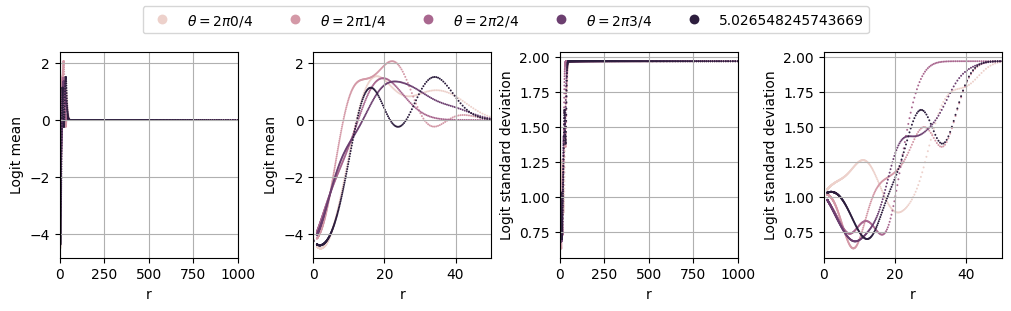

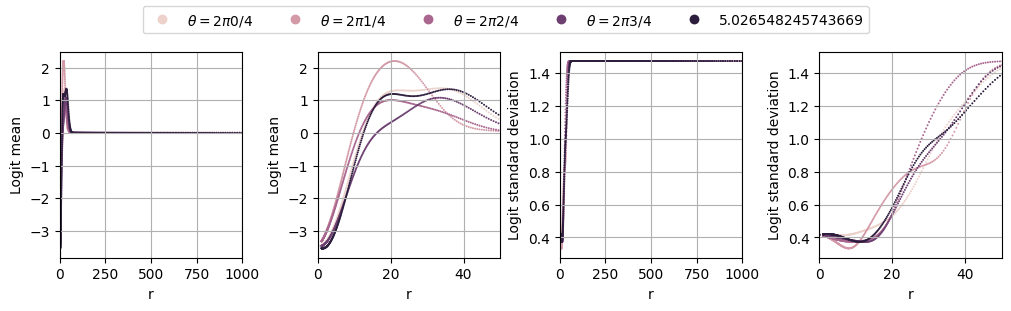

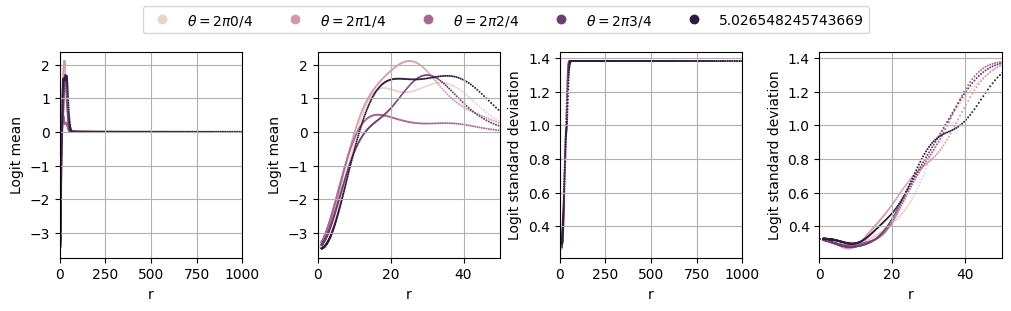

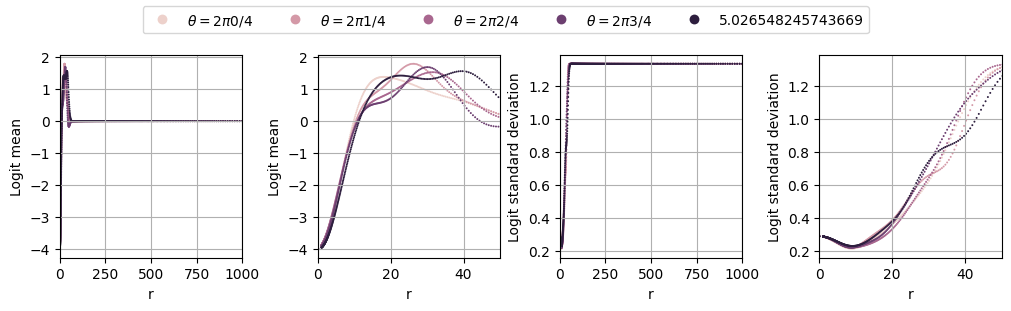

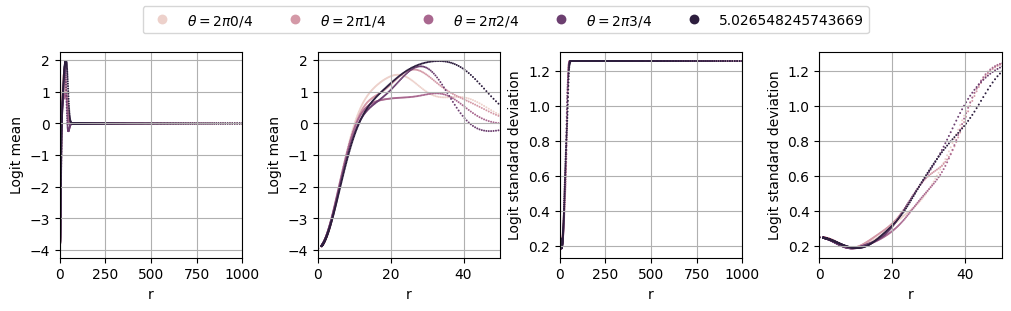

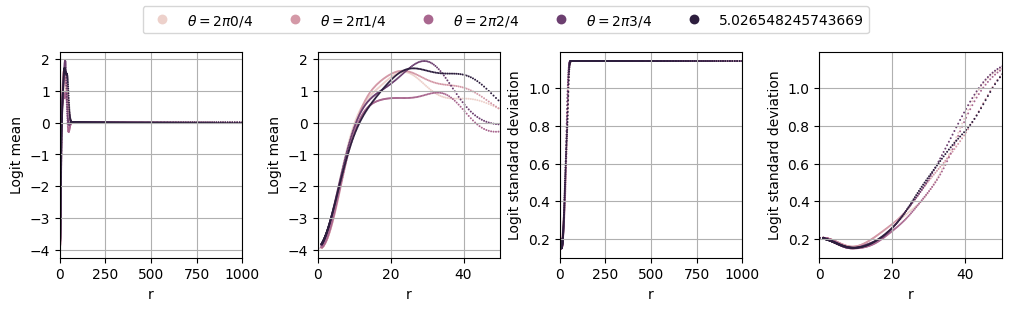

In [ ]:
def plot_large_grid(df, df_truth, prob_key, err_key):

    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 3), layout="constrained")

    #Plot estimated probabilities
    sn.scatterplot(df, x="r", y=prob_key, hue="a1", ax=axs[0], s=2, linewidth=0, alpha=1, legend=False)
    axs[0].set_ylabel("Logit mean", size=10)
    axs[0].set_xlim(0, large_grid_rmax)
    #axs[0].set_ylim(0, 1)

    sn.scatterplot(df, x="r", y=prob_key, hue="a1", ax=axs[1], s=2, alpha=1, linewidth=0, legend="full")
    axs[1].set_ylabel("Logit mean", size=10)
    axs[1].set_xlim(0, grid_rmax)
    #axs[1].set_ylim(0, 1)

    #Plot uncertainties
    sn.scatterplot(df, x="r", y=err_key, hue="a1", ax=axs[2], s=2, linewidth=0, alpha=1, legend=False)
    axs[2].set_ylabel("Logit standard deviation", size=10)
    #axs[2].set_ylim(0, 0.35)
    axs[2].set_xlim(0, large_grid_rmax)

    sn.scatterplot(df, x="r", y=err_key, hue="a1", ax=axs[3], s=2, linewidth=0, alpha=1, legend=False)
    axs[3].set_ylabel("Logit standard deviation", size=10)
    axs[3].set_xlim(0, grid_rmax)
    #axs[3].set_ylim(0, 1)

    handles, labels = axs[1].get_legend_handles_labels()
    len_labels = len(labels) - 1
    for i in range(len_labels):
        labels[i] = rf"$\theta = 2\pi${i}/{len_labels}"
    axs[1].get_legend().remove()
    
    for ax in axs:
        ax.grid(True)
    
    fig.suptitle("    ", fontsize=26)
    fig.legend(handles, labels, loc='upper center', ncol=len_labels+1, labelspacing=0.1, fontsize=10, markerscale=5)


for i in range(len(n_data)):
    plot_large_grid(large_grid_latent_dfs[i], large_grid_data, "Logit_blue", "Std_logit_blue")

In [ ]:
print(adsfas) #stop

In [ ]:
grid_dfs = [0]*(len(n_data))
large_grid_dfs = [0]*(len(n_data))
test_dfs = [0]*(len(n_data))

if load_values==False:
    for i in tqdm(range(len(n_data))):
        grid_dfs[i] = pd.read_csv(f"../data/{gridfile}.csv")
        large_grid_dfs[i] = pd.read_csv(f"../data/{large_gridfile}.csv")
        test_dfs[i] = pd.read_csv(f"../data/{testfile}.csv")
        X_train = train_data[[x1_key, x2_key]][0:n_data[i]]
        Y_train = train_data["class"][0:n_data[i]]
        
        kernel = ov * RBF(length_scale=ls)  # RBF kernel with default parameters
        gp = GaussianProcessClassifier(kernel=kernel)

        print(len(X_train))
        gp.fit(X_train, Y_train)
        test_dfs[i]["Est_prob_blue"] = gp.predict_proba(X_test)[:,1]
        test_dfs[i]["Prediction"] = gp.predict(X_test)

        grid_dfs[i]["Est_prob_blue"] = gp.predict_proba(X_grid)[:,1]
        grid_dfs[i]["Prediction"] = gp.predict(X_grid)

        large_grid_dfs[i]["Est_prob_blue"] = gp.predict_proba(X_large_grid)[:,1]
        large_grid_dfs[i]["Prediction"] = gp.predict(X_large_grid)

        # Save prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                    os.mkdir(f"predictions/{trainfile}")
            test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predictedGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
            grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predictedGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
            large_grid_dfs[i].to_csv(f"predictions/{trainfile}/large_grid_{tag}_predictedGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
else:
    for i in range(len(n_data)):
        test_dfs[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predictedGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
        grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predictedGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
        large_grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/large_grid_{tag}_predictedGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

250


 17%|█▋        | 1/6 [00:17<01:29, 17.96s/it]

500


 33%|███▎      | 2/6 [00:55<01:57, 29.32s/it]

1000


 50%|█████     | 3/6 [02:10<02:30, 50.33s/it]

2000


 67%|██████▋   | 4/6 [04:02<02:28, 74.49s/it]

3000


 83%|████████▎ | 5/6 [07:07<01:54, 114.48s/it]

5000


100%|██████████| 6/6 [12:28<00:00, 124.80s/it]


In [ ]:
test_dfs[0]

class          r        a1         x1         x2  p_c0  p_r_given_c0  \
0         0   4.289633  4.245334  -1.931443  -3.830206   0.5      0.072759   
1         0  17.423602  4.247328  -7.814084 -15.573118   0.5      0.021370   
2         1  17.497000  5.495961  12.349632 -12.394821   0.5      0.021147   
3         1  18.340633  0.669942  14.376446  11.388443   0.5      0.018725   
4         1  17.734816  4.248409  -7.936523 -15.859865   0.5      0.020439   
...     ...        ...       ...        ...        ...   ...           ...   
9995      0   3.222224  2.580172  -2.727611   1.715478   0.5      0.067661   
9996      1  16.659278  0.202857  16.317679   3.356321   0.5      0.023807   
9997      1  18.598490  0.671747  14.557703  11.574849   0.5      0.018034   
9998      0   6.518083  6.116791   6.428058  -1.079573   0.5      0.070799   
9999      1  12.773676  1.753323  -2.318617  12.561481   0.5      0.039707   

      p_c0_given_r  p_c1  p_r_given_c1  p_c1_given_r       p_r  Est_prob_blue  \
0         0.948213   0.5      0.003974      0.051787  0.038366       0.041260   
1         0.279314   0.5      0.055139      0.720686  0.038254       0.555051   
2         0.277902   0.5      0.054949      0.722098  0.038048       0.900716   
3         0.262935   0.5      0.052491      0.737065  0.035608       0.811764   
4         0.273450   0.5      0.054306      0.726550  0.037372       0.572287   
...            ...   ...           ...           ...       ...            ...   
9995      0.980346   0.5      0.001356      0.019654  0.034509       0.058138   
9996      0.295183   0.5      0.056845      0.704817  0.040326       0.744782   
9997      0.258796   0.5      0.051650      0.741204  0.034842       0.814250   
9998      0.822159   0.5      0.015314      0.177841  0.043057       0.065937   
9999      0.419190   0.5      0.055016      0.580810  0.047362       0.497806   

      Prediction  
0              0  
1              1  
2              1  
3              1  
4              1  
...          ...  
9995           0  
9996           1  
9997           1  
9998           0  
9999           0  

[10000 rows x 14 columns]

In [ ]:
test_latent_dfs[0]

class          r        a1         x1         x2  p_c0  p_r_given_c0  \
0         0   4.289633  4.245334  -1.931443  -3.830206   0.5      0.072759   
1         0  17.423602  4.247328  -7.814084 -15.573118   0.5      0.021370   
2         1  17.497000  5.495961  12.349632 -12.394821   0.5      0.021147   
3         1  18.340633  0.669942  14.376446  11.388443   0.5      0.018725   
4         1  17.734816  4.248409  -7.936523 -15.859865   0.5      0.020439   
...     ...        ...       ...        ...        ...   ...           ...   
9995      0   3.222224  2.580172  -2.727611   1.715478   0.5      0.067661   
9996      1  16.659278  0.202857  16.317679   3.356321   0.5      0.023807   
9997      1  18.598490  0.671747  14.557703  11.574849   0.5      0.018034   
9998      0   6.518083  6.116791   6.428058  -1.079573   0.5      0.070799   
9999      1  12.773676  1.753323  -2.318617  12.561481   0.5      0.039707   

      p_c0_given_r  p_c1  p_r_given_c1  p_c1_given_r       p_r  Logit_blue  \
0         0.948213   0.5      0.003974      0.051787  0.038366   -3.531245   
1         0.279314   0.5      0.055139      0.720686  0.038254    0.252083   
2         0.277902   0.5      0.054949      0.722098  0.038048    2.714042   
3         0.262935   0.5      0.052491      0.737065  0.035608    1.768688   
4         0.273450   0.5      0.054306      0.726550  0.037372    0.332484   
...            ...   ...           ...           ...       ...         ...   
9995      0.980346   0.5      0.001356      0.019654  0.034509   -3.110105   
9996      0.295183   0.5      0.056845      0.704817  0.040326    1.259102   
9997      0.258796   0.5      0.051650      0.741204  0.034842    1.794946   
9998      0.822159   0.5      0.015314      0.177841  0.043057   -3.181668   
9999      0.419190   0.5      0.055016      0.580810  0.047362   -0.009887   

      Std_logit_blue  Sigmoid_blue  Prediction  Est_prob_blue  \
0           0.932439      0.028436           0       0.045265   
1           0.798683      0.562689           1       0.556119   
2           1.194733      0.937850           1       0.897762   
3           1.064348      0.854294           1       0.813274   
4           0.804909      0.582364           1       0.573674   
...              ...           ...         ...            ...   
9995        0.875136      0.042692           0       0.061402   
9996        0.936855      0.778871           1       0.747591   
9997        1.078119      0.857533           1       0.815675   
9998        1.152520      0.039861           0       0.070483   
9999        0.753720      0.497528           0       0.497765   

      Est_prob_blue_MC  Std_prob_blue_MC  Sigmoid_std_logit_blue  
0             0.041119          0.042756                0.217570  
1             0.556871          0.173876                0.189693  
2             0.900489          0.105118                0.267586  
3             0.813265          0.148161                0.243521  
4             0.575425          0.174696                0.191024  
...                ...               ...                     ...  
9995          0.057600          0.051960                0.205813  
9996          0.748209          0.157436                0.218464  
9997          0.812750          0.150360                0.246138  
9998          0.066201          0.075705                0.259971  
9999          0.496323          0.166269                0.179989  

[10000 rows x 20 columns]

In [ ]:
sqrt(0.5*0.5)/()

## Not properly normalized

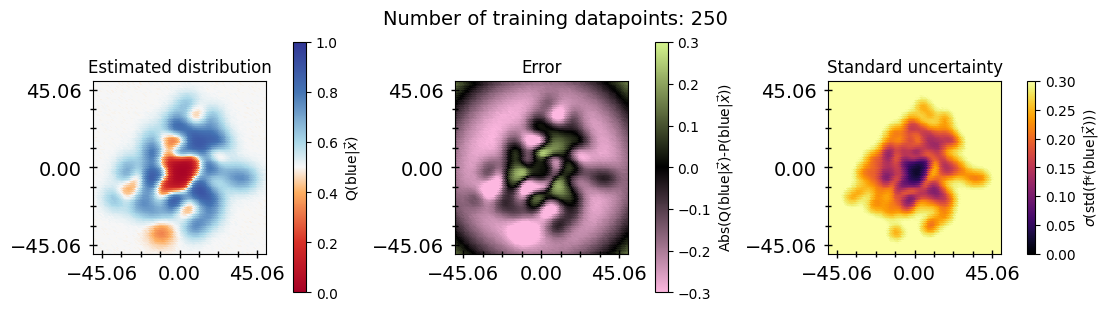

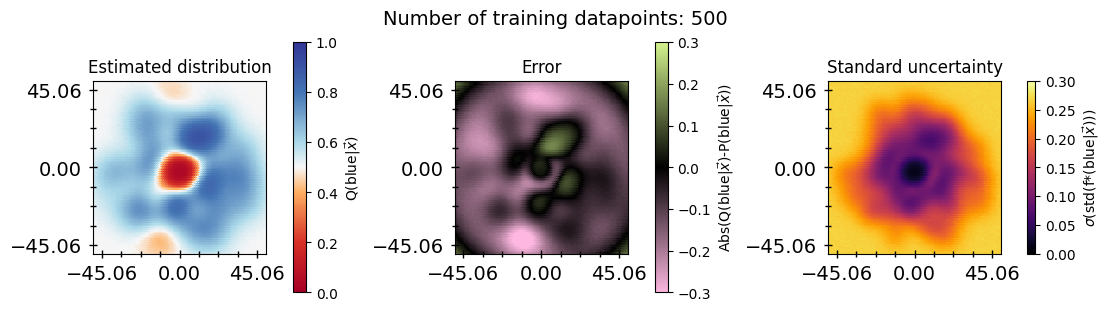

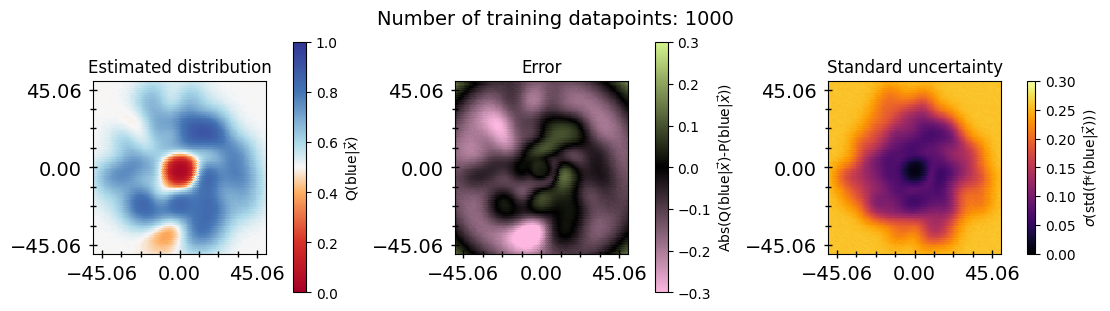

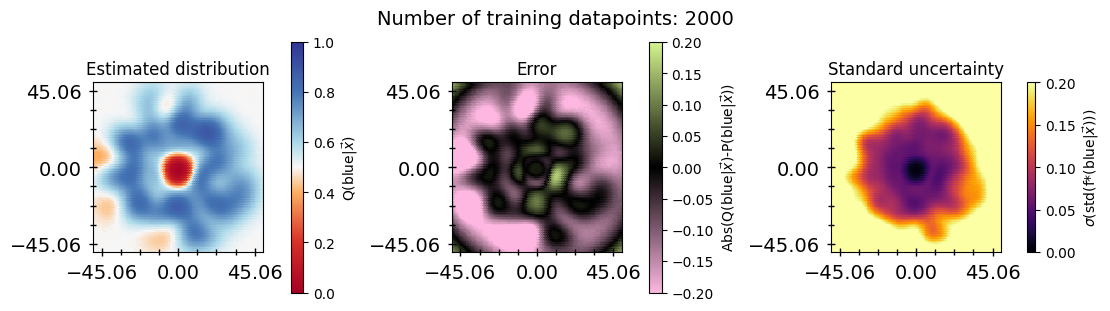

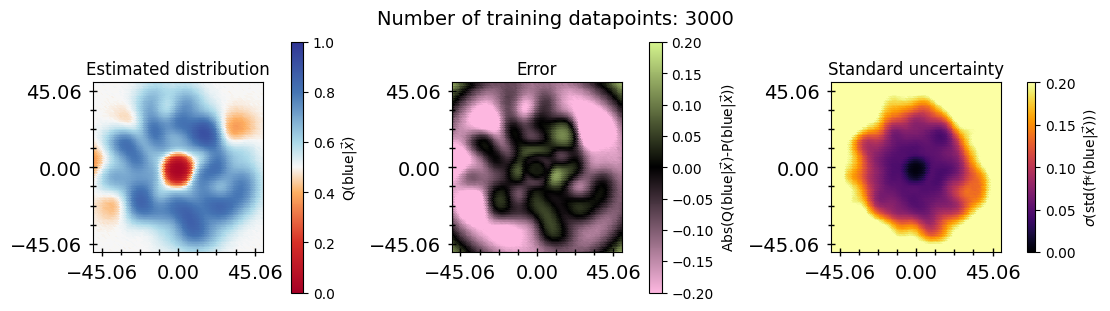

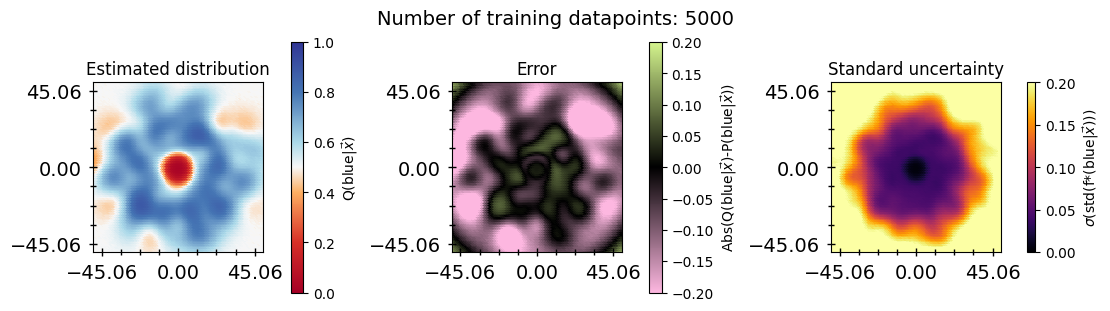

In [ ]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

    axs[0] = plot_results(grid_latent_dfs[i], "Est_prob_blue_MC", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_latent_dfs[i], grid_data, "Est_prob_blue_MC", "p_c1_given_r", axs[1], r"Error", max_val=max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_std(grid_latent_dfs[i], "Std_prob_blue_MC", axs[2], "Standard uncertainty", grid=True, max_val=max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"$\sigma$(std(f*(blue|$\vec{x}$)))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)


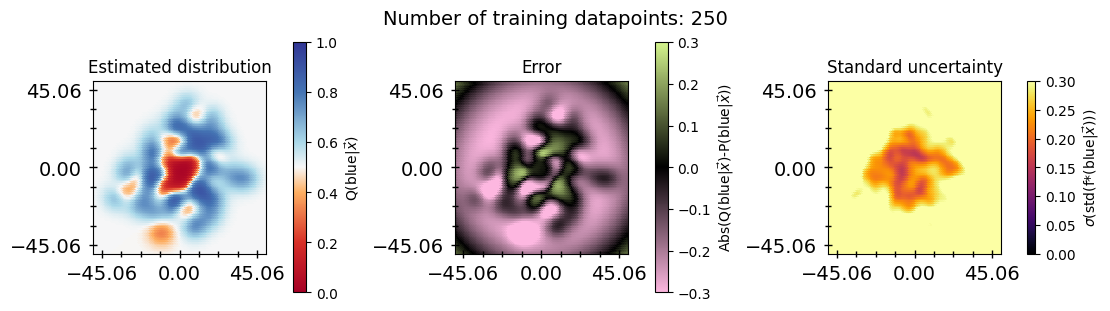

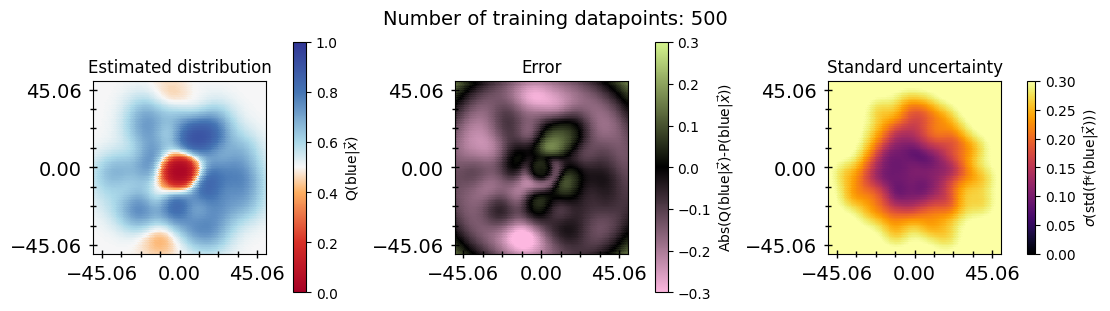

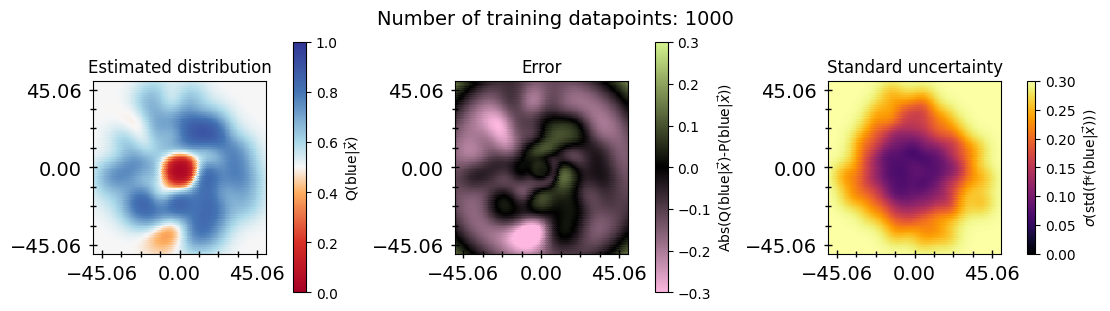

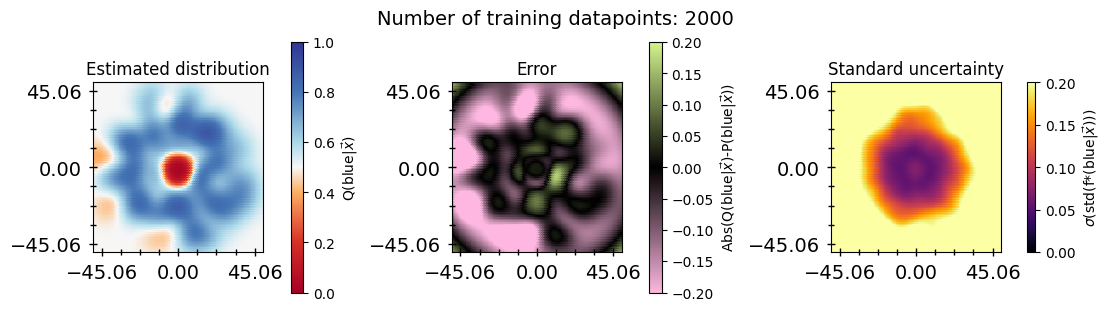

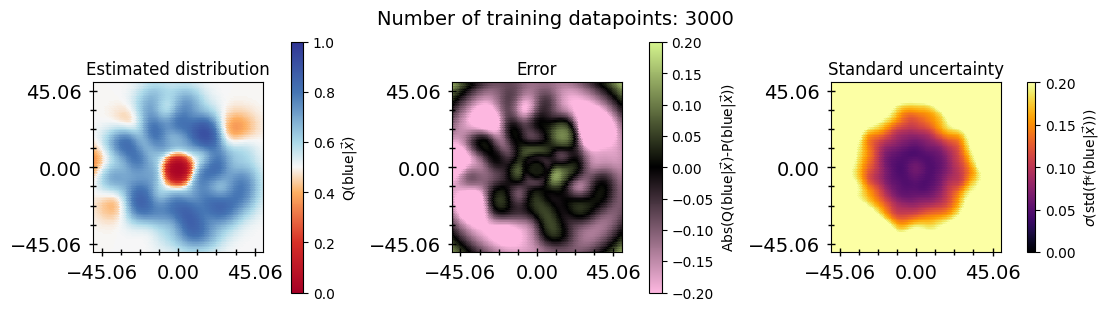

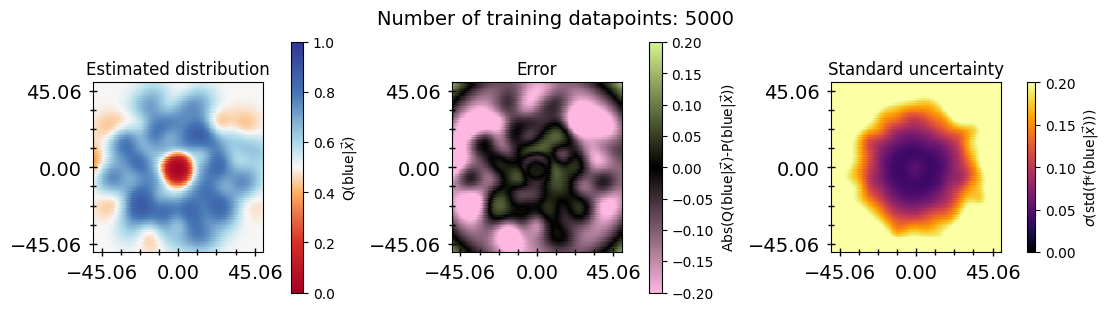

In [ ]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

    axs[0] = plot_results(grid_latent_dfs[i], "Est_prob_blue", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_latent_dfs[i], grid_data, "Est_prob_blue", "p_c1_given_r", axs[1], r"Error", max_val=max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_std(grid_latent_dfs[i], "Sigmoid_std_logit_blue", axs[2], "Standard uncertainty", grid=True, max_val=max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"$\sigma$(std(f*(blue|$\vec{x}$)))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)


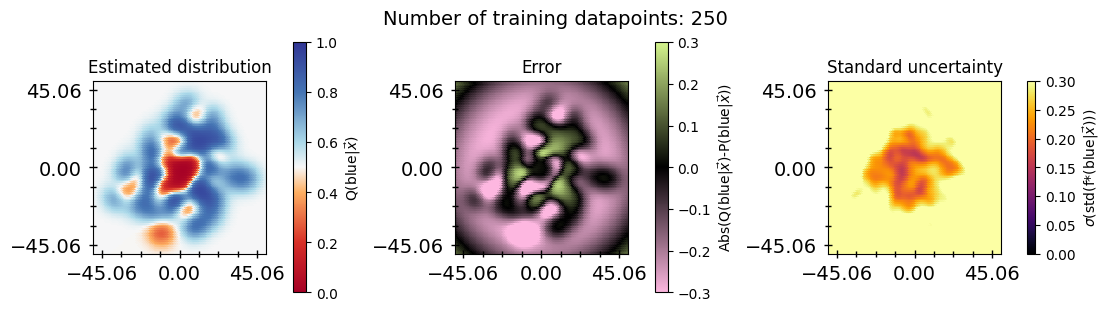

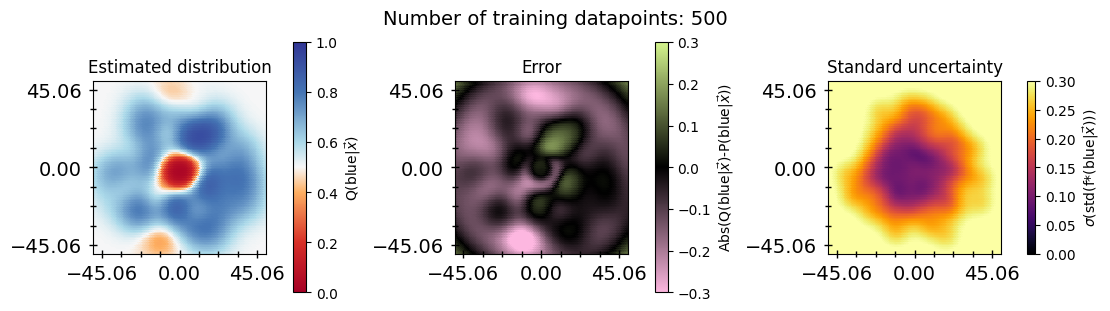

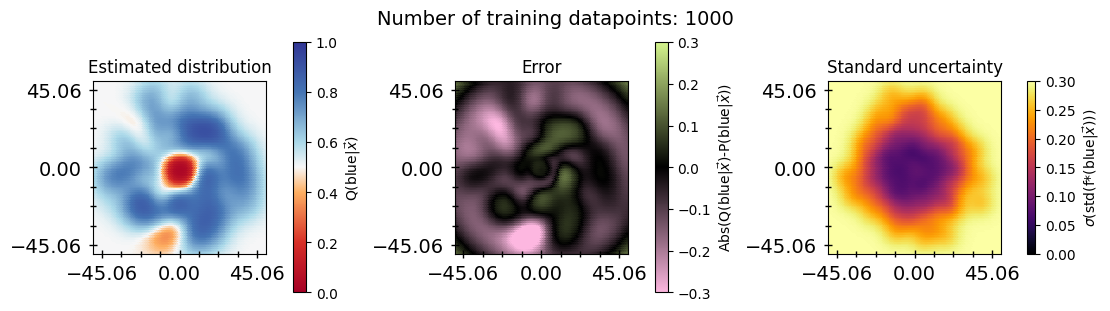

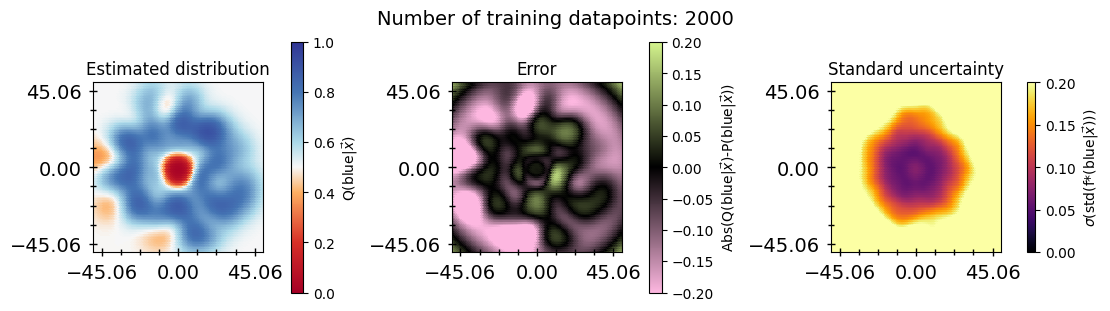

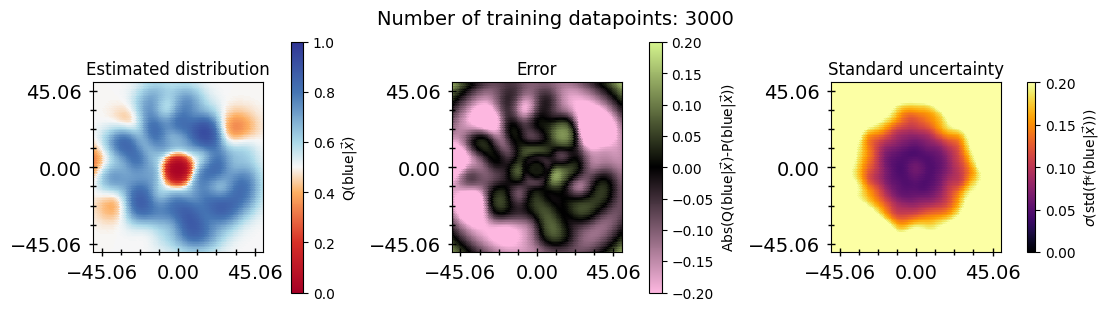

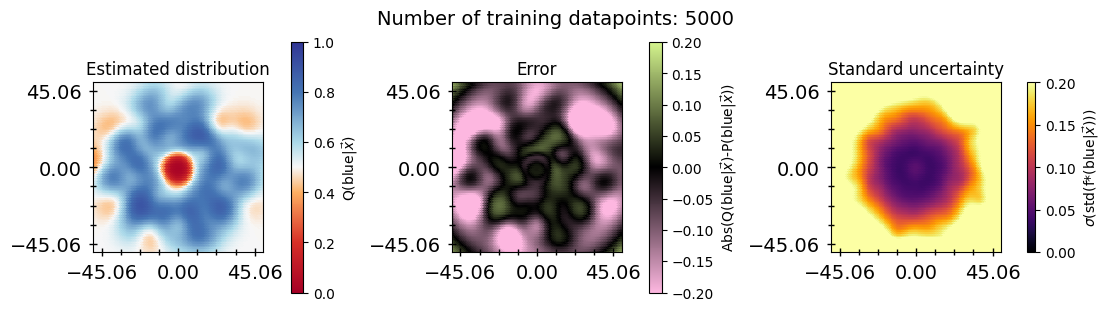

In [ ]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

    axs[0] = plot_results(grid_latent_dfs[i], "Sigmoid_blue", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_latent_dfs[i], grid_data, "Sigmoid_blue", "p_c1_given_r", axs[1], r"Error", max_val=max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_std(grid_latent_dfs[i], "Sigmoid_std_logit_blue", axs[2], "Standard uncertainty", grid=True, max_val=max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"$\sigma$(std(f*(blue|$\vec{x}$)))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)


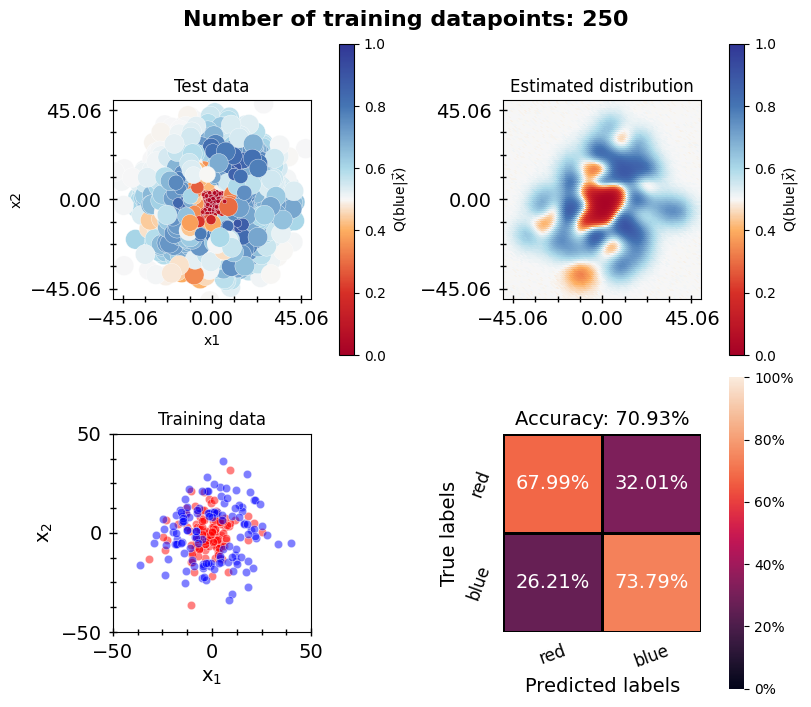

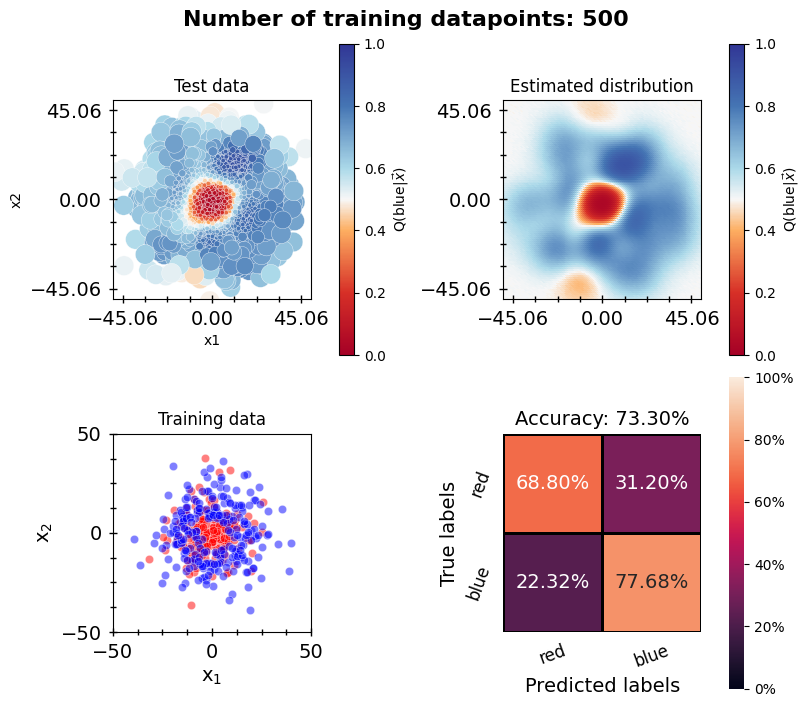

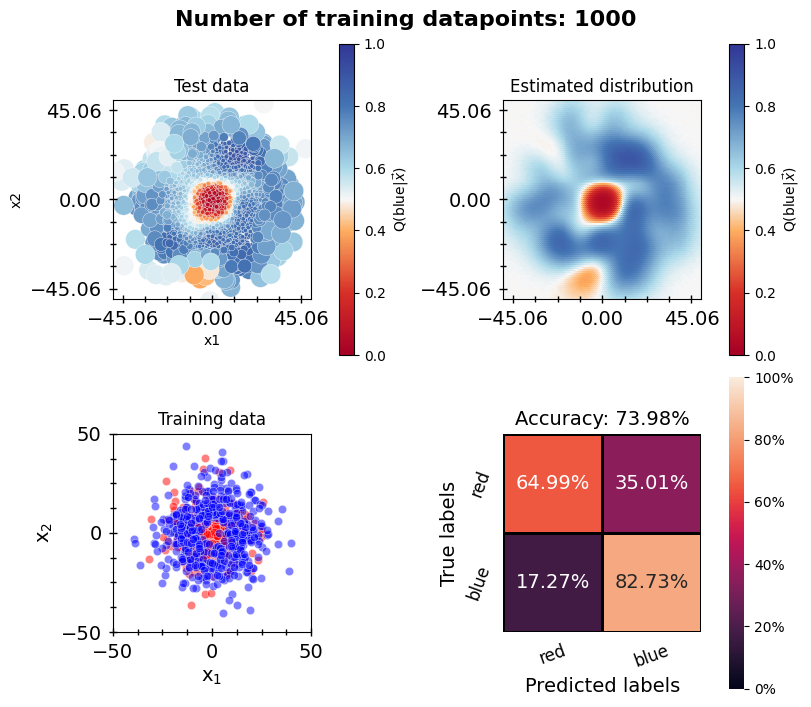

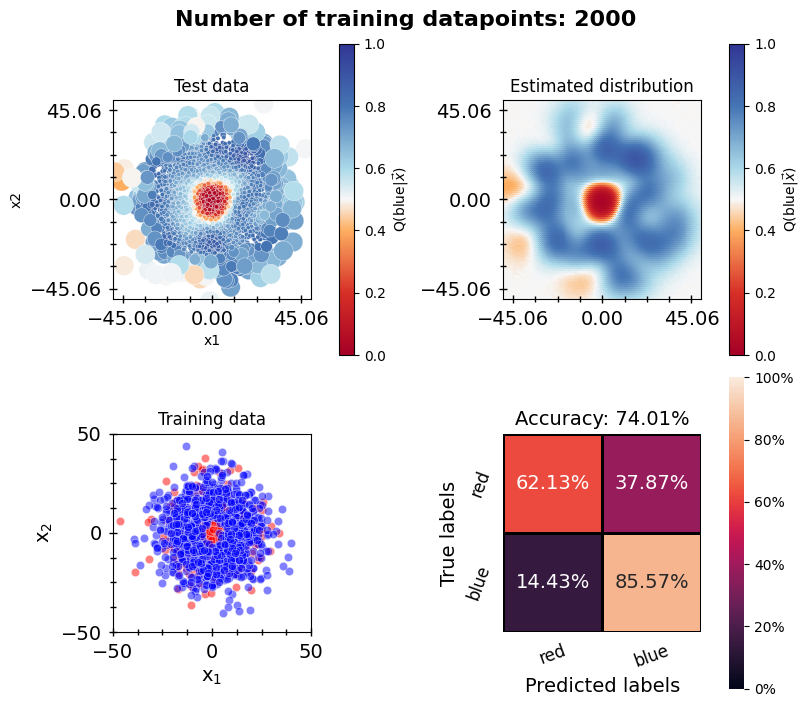

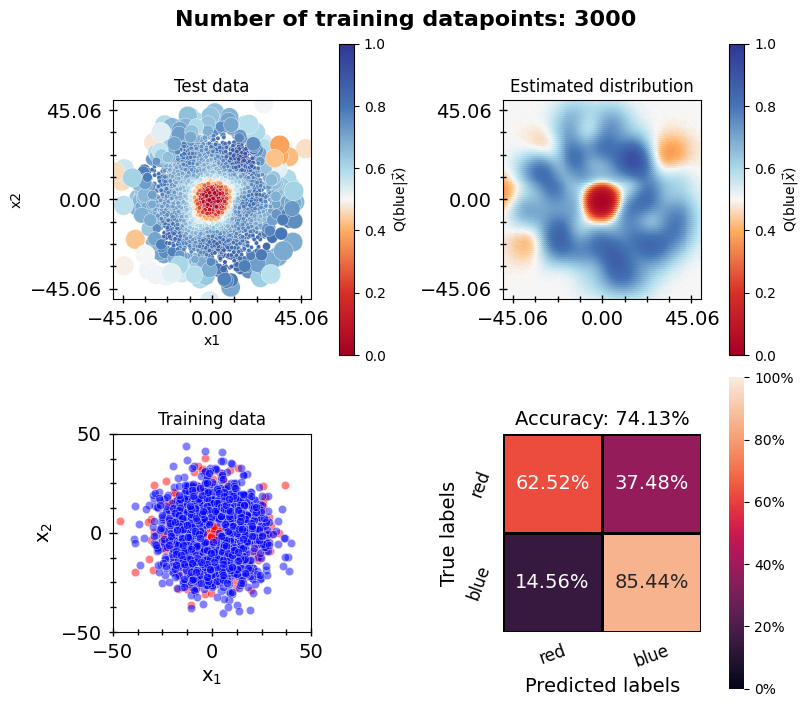

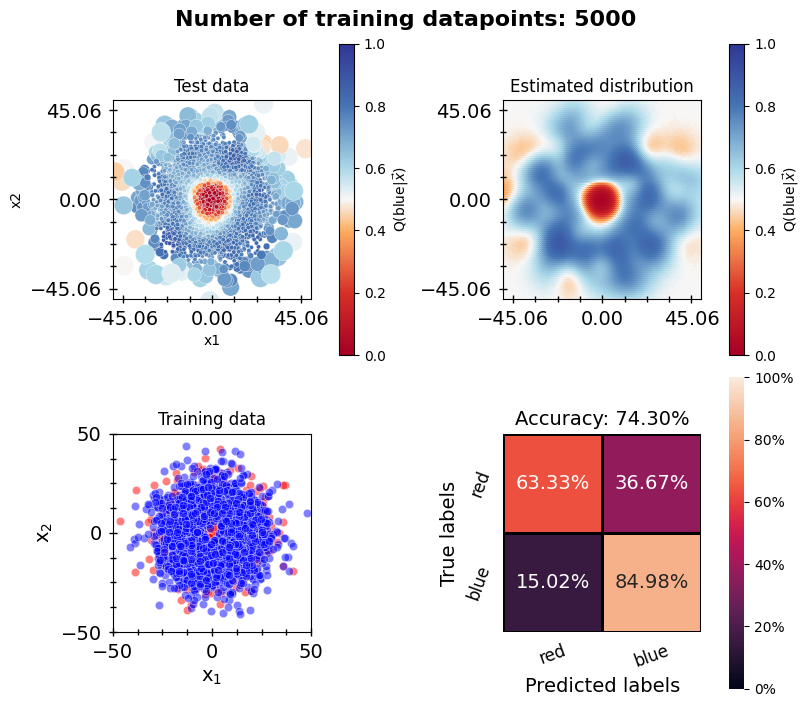

In [ ]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    axs[0][0] = plot_results(test_latent_dfs[i], "Est_prob_blue_MC", axs[0][0], "Test data", error_key="Std_prob_blue_MC", rmax=grid_rmax)
    axs[0][1] = plot_results(grid_latent_dfs[i], "Est_prob_blue_MC", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data", rmax=grid_rmax)
    axs[1][1] = plot_conf_matrix(test_latent_dfs[i], "class", "Prediction", ["red", "blue"], axs[1][1])

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

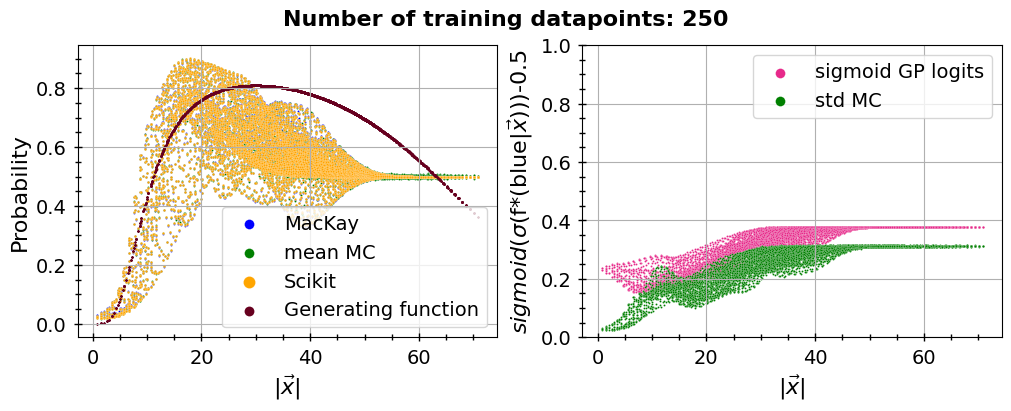

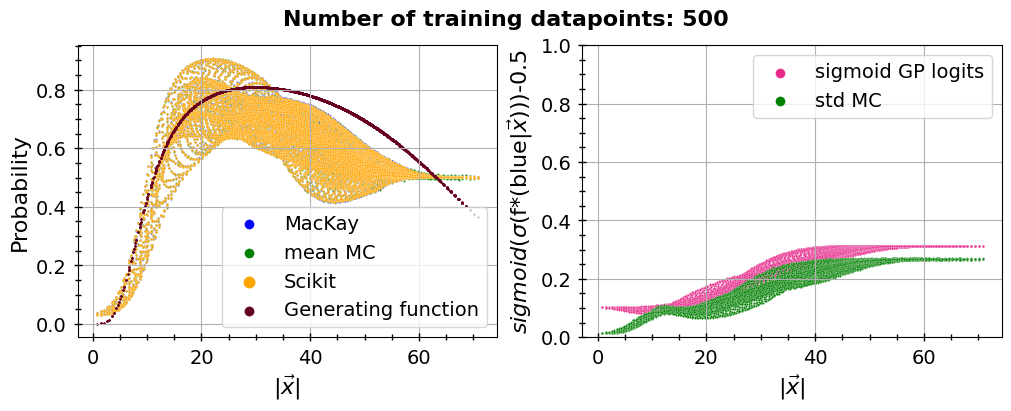

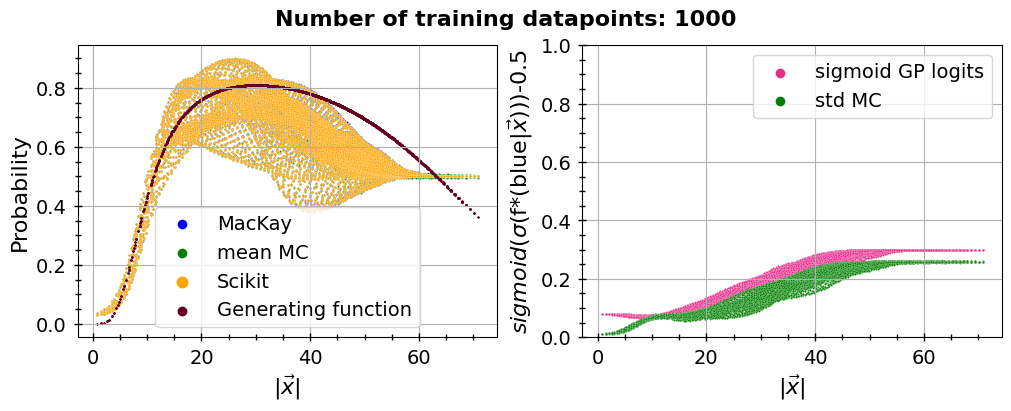

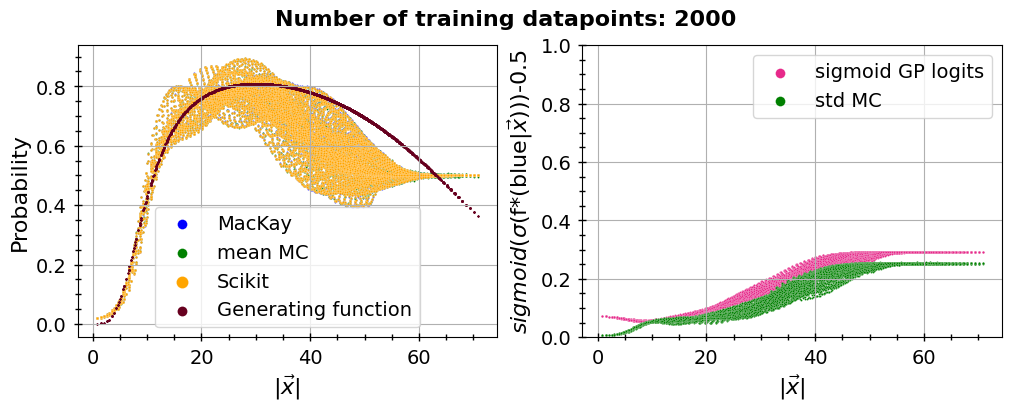

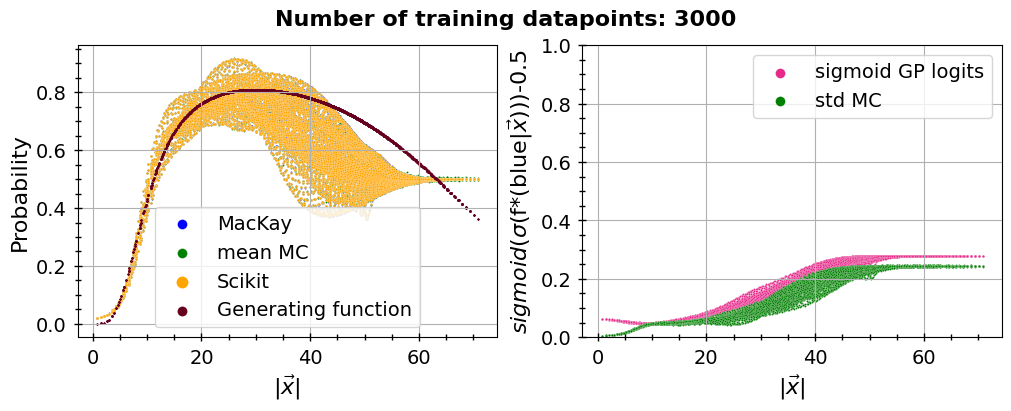

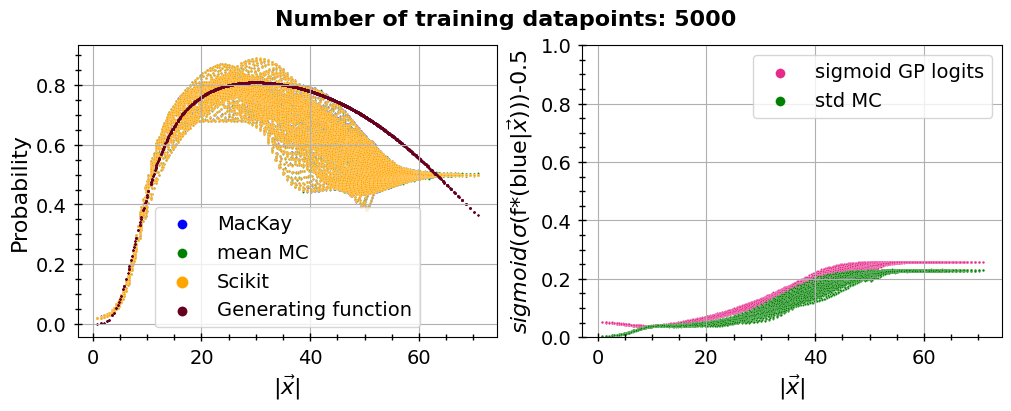

In [ ]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    #sn.scatterplot(grid_latent_dfs[i], x="r", y="Sigmoid_blue", s=2, ax = axs[0], label="sigmoid GP logits", color="#e7298a")
    sn.scatterplot(grid_latent_dfs[i], x="r", y="Est_prob_blue", s=2, ax = axs[0], label="MacKay", color="blue")
    sn.scatterplot(grid_latent_dfs[i], x="r", y="Est_prob_blue_MC", s=2, ax = axs[0], label="mean MC", color="green")
    sn.scatterplot(grid_dfs[i], x="r", y="Est_prob_blue", s=3, ax = axs[0], label="Scikit", color="orange")
    sn.scatterplot(grid_data, x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"Probability", fontsize=16)

    sn.scatterplot(grid_latent_dfs[i], x="r", y="Sigmoid_std_logit_blue", s=2, ax = axs[1], label="sigmoid GP logits", color="#e7298a")
    sn.scatterplot(grid_latent_dfs[i], x="r", y="Std_prob_blue_MC", s=2, ax = axs[1], label="std MC", color="green")
    axs[1].set_ylabel(r"$sigmoid(\sigma$(f*(blue|$\vec{x}$)))-0.5", fontsize=16)
    axs[1].set_ylim(0, 1)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

Text(0, 0.5, '$Q_{MC} - Q_{MacKay}$')

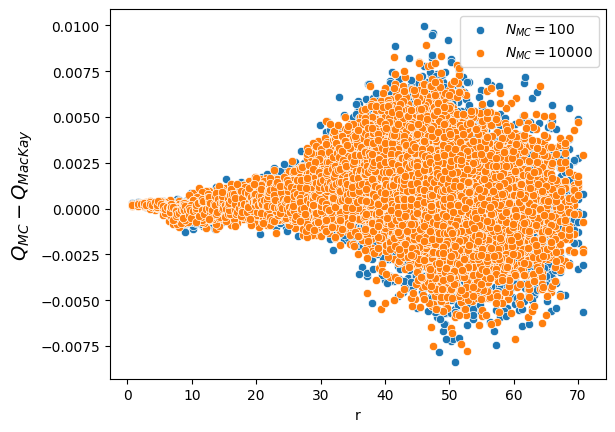

In [ ]:
grid_latent_dfs[-1]["Est_prob_blue_MC_10000"], grid_latent_dfs[-1]["Std_prob_blue_MC_10000"] = MC_est_mu_std(grid_latent_dfs[-1]["Logit_blue"], grid_latent_dfs[-1]["Std_logit_blue"], N_samples=10000)
grid_latent_dfs[-1]["diff_est_prob100_Mackay"] = grid_latent_dfs[-1]["Est_prob_blue"] - grid_latent_dfs[-1]["Est_prob_blue_MC"]
grid_latent_dfs[-1]["diff_est_prob10000_Mackay"] = grid_latent_dfs[-1]["Est_prob_blue"] - grid_latent_dfs[-1]["Est_prob_blue_MC_10000"]
sn.scatterplot(grid_latent_dfs[-1], x="r", y="diff_est_prob100_Mackay", label=r"$N_{MC}=100$")
sn.scatterplot(grid_latent_dfs[-1], x="r", y="diff_est_prob10000_Mackay", label=r"$N_{MC}=10000$")
plt.legend()
plt.ylabel(r"$Q_{MC} - Q_{MacKay}$", fontsize=14)

Text(0, 0.5, '$Q_{Scikit} - Q_{MacKay}$')

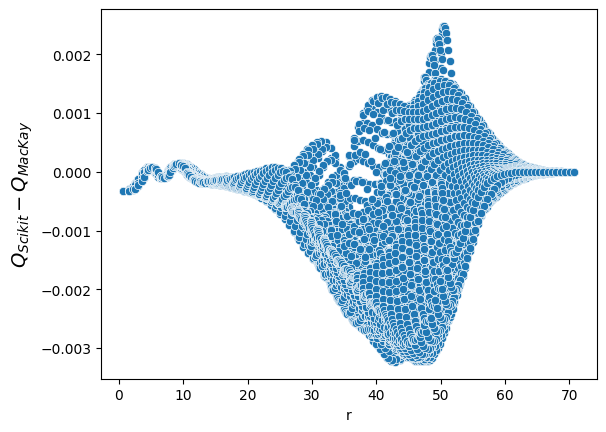

In [ ]:
#grid_latent_dfs[-1]["Est_prob_blue_MC_10000"], grid_latent_dfs[-1]["Std_prob_blue_MC_10000"] = MC_est_mu_std(grid_latent_dfs[-1]["Logit_blue"], grid_latent_dfs[-1]["Std_logit_blue"], N_samples=10000)
grid_latent_dfs[-1]["diff_Mackay_scikit"] = grid_dfs[-1]["Est_prob_blue"] - grid_latent_dfs[-1]["Est_prob_blue"]
sn.scatterplot(grid_latent_dfs[-1], x="r", y="diff_Mackay_scikit")
plt.ylabel(r"$Q_{Scikit} - Q_{MacKay}$", fontsize=14)

Text(0, 0.5, '$Q_{Scikit} - Q_{MC}$')

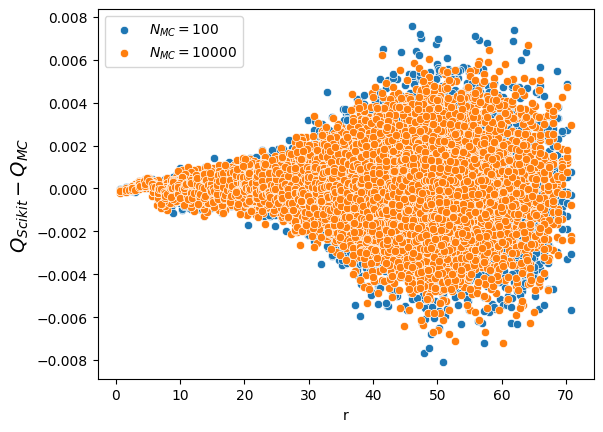

In [ ]:
#grid_latent_dfs[-1]["Est_prob_blue_MC_10000"], grid_latent_dfs[-1]["Std_prob_blue_MC_10000"] = MC_est_mu_std(grid_latent_dfs[-1]["Logit_blue"], grid_latent_dfs[-1]["Std_logit_blue"], N_samples=10000)
grid_latent_dfs[-1]["diff_est_prob100_scikit"] = grid_dfs[-1]["Est_prob_blue"] - grid_latent_dfs[-1]["Est_prob_blue_MC"]
grid_latent_dfs[-1]["diff_est_prob10000_scikit"] = grid_dfs[-1]["Est_prob_blue"] - grid_latent_dfs[-1]["Est_prob_blue_MC_10000"]
sn.scatterplot(grid_latent_dfs[-1], x="r", y="diff_est_prob100_scikit", label=r"$N_{MC}=100$")
sn.scatterplot(grid_latent_dfs[-1], x="r", y="diff_est_prob10000_scikit", label=r"$N_{MC}=10000$")
plt.legend()
plt.ylabel(r"$Q_{Scikit} - Q_{MC}$", fontsize=14)

In [ ]:
scores = calculate_metrics(test_latent_dfs, grid_latent_dfs, n_data, grid_data, test_data, 
                           "Prediction", "Est_prob_blue", "Sigmoid_std_logit_blue")
print(scores)

   N data       ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.709371  0.767492  0.054099  0.157327  0.230376  0.049434   
1     500  0.732973  0.790984  0.045136  0.107220  0.120754  0.039959   
2    1000  0.739774  0.793738  0.022358  0.096556  0.098084  0.039008   
3    2000  0.740074  0.797967  0.016362  0.092506  0.080883  0.035552   
4    3000  0.741274  0.801456  0.017935  0.094330  0.069288  0.032220   
5    5000  0.742974  0.802942  0.013925  0.092169  0.056931  0.028162   

   Mean KL-div test  Mean KL-div grid   LogLoss  Q-P dist       ECE       MCE  \
0          0.029310          0.032382  0.570658  0.113107  0.075918  0.165960   
1          0.012110          0.015282  0.539305  0.071132  0.055956  0.132313   
2          0.006447          0.013794  0.529618  0.055275  0.037311  0.087016   
3          0.003572          0.013835  0.523058  0.039352  0.018892  0.084465   
4          0.002981          0.014869  0.521366  0.035397  0.015258  0.109436   
5 